In [3]:
from Rosenbrock import Rosenbrock_dist
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import tensorflow as tf

In [2]:
Bana_dist = Rosenbrock_dist()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


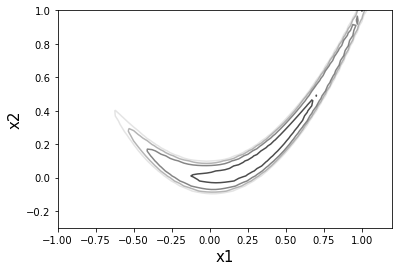

In [3]:
Bana_dist.draw_post()

<a href="http://blog.enthought.com/general/visualizing-uncertainty/#.XqC1GdP7RTY"> Plotting reference</a>

In [4]:
def pdense(x, y, sigma, M=1000):
    """ Plot probability density of y with known stddev sigma
    """
    assert len(x) == len(y) and len(x) == len(sigma)
    N = len(x)
    # TODO: better y ranging
    ymin, ymax = min(y - 2 * sigma), max(y + 2 * sigma)
    yy = np.linspace(ymin, ymax, M)
    a = [np.exp(-((Y - yy) / s) ** 2) / s for Y, s in zip(y, sigma)]
    A = np.array(a)
    A = A.reshape(N, M)
    plt.imshow(-A.T, cmap='gray', aspect='auto',
               origin='lower', extent=(min(x)[0], max(x)[0], ymin, ymax))
    plt.title('Density plot')

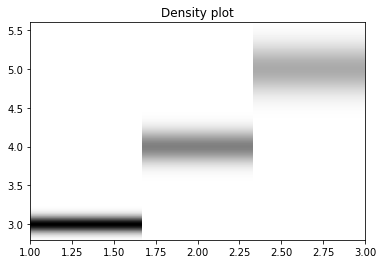

In [5]:
x = np.array([[1],[2],[3]])
y = np.array([[3],[4],[5]])
s2 = np.array([[0.1],[0.2],[0.3]])
pdense(x, y, s2, M=1000)